# 처음부터 ReAct 에이전트 만드는 방법

!!! 정보 "전제 조건"
    이 가이드는 다음 항목에 대한 이해를 전제로 합니다:
    
    - [도구 호출 에이전트](../../concepts/agentic_concepts/#tool-calling-agent)
    - [채팅 모델](https://python.langchain.com/docs/concepts/chat_models/)
    - [메시지](https://python.langchain.com/docs/concepts/messages/)
    - [LangGraph 용어집](../../concepts/low_level/)

미리 구축된 ReAct 에이전트 [create_react_agent][langgraph.prebuilt.chat_agent_executor.create_react_agent]를 사용하는 것은 시작하는 데 좋은 방법이지만, 때때로 더 많은 제어와 사용자 지정을 원할 수 있습니다. 그런 경우에 커스텀 ReAct 에이전트를 만들 수 있습니다. 이 가이드는 LangGraph를 사용하여 처음부터 ReAct 에이전트를 구현하는 방법을 보여줍니다.

## 설정

우선, 필요한 패키지를 설치하고 API 키를 설정해봅시다:


In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-openai


In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")


<div class="admonition tip">
     <p class="admonition-title">더 나은 디버깅을 위해 <a href="https://smith.langchain.com">LangSmith</a> 설정하기</p>
     <p style="padding-top: 5px;">
         LangSmith에 가입하여 문제를 빠르게 찾아내고 LangGraph 프로젝트의 성능을 개선하세요. LangSmith는 LangGraph로 구축된 LLM 앱을 디버그, 테스트 및 모니터링하기 위해 추적 데이터를 사용할 수 있게 해줍니다. 시작하는 방법에 대한 자세한 내용은 <a href="https://docs.smith.langchain.com">문서</a>를 참조하세요. 
     </p>
 </div>


## ReAct 에이전트 생성

필요한 패키지를 설치하고 환경 변수를 설정했으니, 이제 ReAct 에이전트를 코딩할 수 있습니다!

### 그래프 상태 정의

이 예제에서는 가장 기본적인 ReAct 상태를 정의할 것입니다. 이 상태는 단순히 메시지 리스트를 포함할 것입니다.

특정 사용 사례에 따라 필요에 맞게 다른 상태 키를 추가하셔도 됩니다.


In [4]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]


### 도구 및 모델 정의

다음으로, 우리의 예제에 사용할 도구와 모델을 정의해 보겠습니다.


In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

model = ChatOpenAI(model="gpt-4o-mini")


@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"


tools = [get_weather]

model = model.bind_tools(tools)


### 노드와 엣지 정의하기

다음으로 노드와 엣지를 정의해 보겠습니다. 기본 ReAct 에이전트에는 모델을 호출하는 노드와 도구를 사용하는 노드의 두 가지 노드만 있지만, 이 기본 구조를 수정하여 귀하의 사용 사례에 더 적합하게 만들 수 있습니다. 여기서 정의하는 도구 노드는 미리 구축된 [`ToolNode`](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/)의 단순화된 버전으로, 몇 가지 추가 기능이 있습니다.

구조화된 출력을 추가하는 [노드](https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/)나 외부 작업을 수행하는 노드(이메일 전송, 캘린더 이벤트 추가 등)를 추가하고 싶을 수도 있습니다. 또는 `call_model` 노드의 작동 방식과 `should_continue`가 도구를 호출할지 결정하는 방식을 변경하고 싶을 수도 있습니다 - 가능성은 무궁무진하며 LangGraph는 이 기본 구조를 귀하의 특정 사용 사례에 맞게 쉽게 사용자 정의할 수 있도록 해줍니다.


In [6]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


### 그래프 정의

이제 모든 노드와 엣지를 정의했으므로 그래프를 정의하고 컴파일할 수 있습니다. 더 많은 노드를 추가했거나 다른 엣지를 추가한 경우, 특정 용도에 맞게 이 내용을 수정해야 합니다.


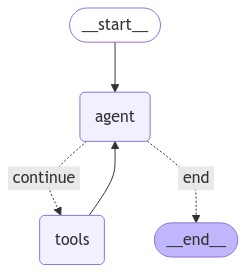

In [7]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


## ReAct 에이전트 사용하기

이제 우리의 ReAct 에이전트를 생성했으니, 실제로 테스트해 봅시다!


In [8]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))


================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_azW0cQ4XjWWj0IAkWAxq9nLB)
 Call ID: call_azW0cQ4XjWWj0IAkWAxq9nLB
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

"It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."
================================== Ai Message ==================================

The weather in San Francisco is sunny! However, it seems there's a playful warning for Geminis. Enjoy the sunshine!


완벽합니다! 그래프가 `get_weather` 도구를 올바르게 호출하고 도구에서 정보를 받은 후 사용자에게 응답합니다.
